In [90]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')
import pwa_cluster as pwac

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data from Experiment

In [92]:
filestem = '../../pwa_id/'
filename = filestem + 'csv/lmpc-9915.h5' #lmpc-9915.h5  rec-9915.h5

f = h5py.File(filename, 'r')

lmpc_data = {}

for key in f.keys():
    print(str(f[key]), key)
    if type(f[key]) == h5py._hl.dataset.Dataset:
        lmpc_data[key] = np.array(f[key])
    

<HDF5 dataset "c_Psi": shape (3, 2931), type "<f8"> c_Psi
<HDF5 dataset "c_Vx": shape (3, 2931), type "<f8"> c_Vx
<HDF5 dataset "c_Vy": shape (4, 2931), type "<f8"> c_Vy
<HDF5 dataset "cmd": shape (2, 2931), type "<f8"> cmd
<HDF5 dataset "coeffConst": shape (10000, 5, 2, 6), type "<f8"> coeffConst
<HDF5 dataset "coeffCost": shape (10000, 2, 6), type "<f8"> coeffCost
<HDF5 dataset "coeffX": shape (9, 2931), type "<f8"> coeffX
<HDF5 dataset "coeffY": shape (9, 2931), type "<f8"> coeffY
<HDF5 dataset "cost": shape (6, 2931), type "<f8"> cost
<HDF5 dataset "cpsi": shape (30, 3, 5000), type "<f8"> cpsi
<HDF5 dataset "curv": shape (9, 2931), type "<f8"> curv
<HDF5 dataset "cvx": shape (30, 3, 5000), type "<f8"> cvx
<HDF5 dataset "cvy": shape (30, 4, 5000), type "<f8"> cvy
<HDF5 dataset "eps_alpha": shape (30, 5000, 6), type "<f8"> eps_alpha
<HDF5 dataset "final_counter": shape (29,), type "<f8"> final_counter
<HDF5 dataset "input": shape (30, 2, 5000), type "<f8"> input
<HDF5 group "/lapStat

In [94]:
states = lmpc_data["state"]
inputs = lmpc_data["cmd"]
print(states.shape)

(7, 2931)


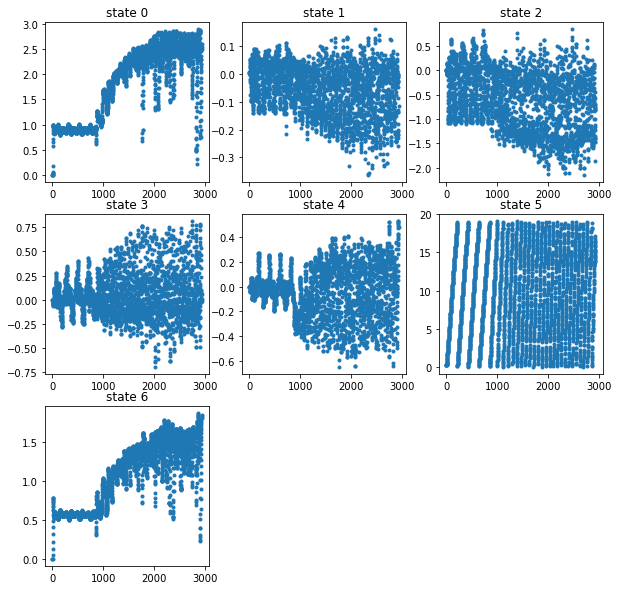

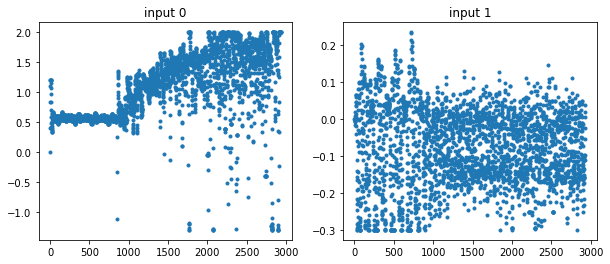

In [95]:
plt.figure(figsize=[10,10]);
for ind in range(states.shape[0]):
    plt.subplot(3,3,ind+1); plt.plot(states[ind], '.'); plt.title('state ' + str(ind))

plt.figure(figsize=[10,4]);
for ind in range(inputs.shape[0]):
    plt.subplot(1,2,ind+1); plt.plot(inputs[ind], '.'); plt.title('input ' + str(ind))

# shift control and state by one -- pick s (where in track) and v_x (speed)

# states: 0 vx, 1 vy, 2 yaw (psi) rate, 3 psi, 4 ey, 5 s, (low pass) filtered vx/acc
# inputs: acceleration, steering
# acceleration, speed, psi dot, vy (symmetric around vy pos or neg)

In [80]:
y.shape

(2930, 6)

In [96]:
# not using final state -- filtered version of first state
y = states[:-1,1:].T
z = np.vstack([states[:-1,:-1], inputs[:,:-1]]).T # to do: correct indexing on inputs?

In [97]:
clustering = pwac.ClusterPWA.from_num_clusters(z, y, 10, z_cutoff=6)


In [98]:
clustering.fit_clusters(verbose=True)

assigning datapoints to clusters
updating models
4.25906031685
assigning datapoints to clusters
updating models
1.64374783887
assigning datapoints to clusters
updating models
1.05478741746
assigning datapoints to clusters
updating models
0.445559652124
assigning datapoints to clusters
updating models
0.209893594634
assigning datapoints to clusters
updating models
0.113407835566
assigning datapoints to clusters
updating models
0.0839015050377
assigning datapoints to clusters
updating models
0.0566895261943
assigning datapoints to clusters
updating models
0.0429422442643
assigning datapoints to clusters
updating models
0.0284022178056
assigning datapoints to clusters
updating models
0.0279320169109
assigning datapoints to clusters
updating models
0.0140838641844
assigning datapoints to clusters
updating models
0.00956473859691
assigning datapoints to clusters
updating models
0.00613239088933
assigning datapoints to clusters
updating models
0.0
done


In [99]:
centroids_first = clustering.centroids.copy()
cluster_labels_first = clustering.cluster_labels.copy()
thetas_first = clustering.thetas.copy()

In [100]:
clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 421920, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 26440, constraints m = 52740
Cones:	linear vars: 52740
Setup time: 1.07e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.19e+00  5.24e+00  9.79e-01 -2.25e+01  2.35e+01  1.10e-14  1.00e-01 
   100| 1.39e-01  3.12e-01  1.29e-02  7.03e+00  7.23e+00  2.30e-15  3.67e+00 
   200| 1.25e-01  1.70e-01  1.29e-02  5.48e+00  5.63e+00  1.79e-15  8.09e+00 
   300| 1.05e-01  1.45e-01  1.83e-02  4.22e+00  4.40e

In [101]:
centroids = clustering.centroids
cluster_labels = clustering.cluster_labels
thetas = clustering.thetas

In [102]:
y_ind = 0
z_ind = [5,0]

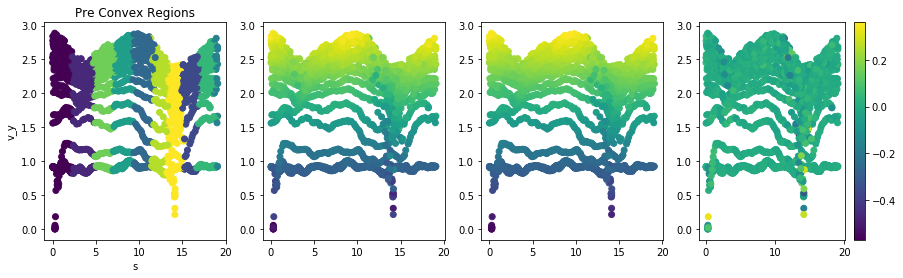

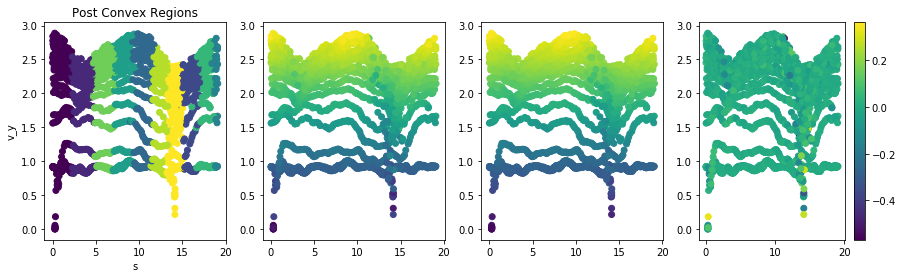

In [104]:
yhats_ind = []; yhats = []
yhats_ind_first = []; yhats_first = []

for i in range(z.shape[0]):
    yhat = thetas[int(cluster_labels[i])].T.dot(np.hstack([z[i], 1]))
    yhat_first = thetas_first[int(cluster_labels_first[i])].T.dot(np.hstack([z[i], 1]))
    yhats_ind.append(yhat[y_ind]);yhats.append(yhat)
    yhats_ind_first.append(yhat_first[y_ind]);yhats_first.append(yhat_first)

    
plt.figure(figsize=[15,4]); 
plt.subplot(1,4,1)
plt.title("Pre Convex Regions")
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=cluster_labels_first); #plt.axis('equal'); plt.colorbar()
plt.xlabel('s')
plt.ylabel('v_y')
plt.subplot(1,4,2)
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=y[:,y_ind]); #plt.axis('equal'); plt.colorbar()
plt.subplot(1,4,3)
#plt.imshow(yhat, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=yhats_ind_first); #plt.axis('equal'); plt.colorbar()
plt.subplot(1,4,4)
#plt.imshow(yhat, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=(y[:,y_ind]-yhats_ind_first));  plt.colorbar() #plt.axis('equal');


plt.figure(figsize=[15,4]); 
plt.subplot(1,4,1)
plt.title("Post Convex Regions")
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=cluster_labels); #plt.axis('equal'); plt.colorbar()
plt.xlabel('s')
plt.ylabel('v_y')
plt.subplot(1,4,2)
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=y[:,y_ind]); #plt.axis('equal'); plt.colorbar()
plt.subplot(1,4,3)
#plt.imshow(yhat, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=yhats_ind); #plt.axis('equal'); plt.colorbar()
plt.subplot(1,4,4)
#plt.imshow(yhat, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.scatter(z[:,z_ind[0]], z[:,z_ind[1]], c=(y[:,y_ind]-yhats_ind));  plt.colorbar() #plt.axis('equal');

## One Step Prediction Error
The one step prediction error on this training data is:

In [108]:
prediction_errors_first = y - np.array(yhats_first)
prediction_errors = y - np.array(yhats)

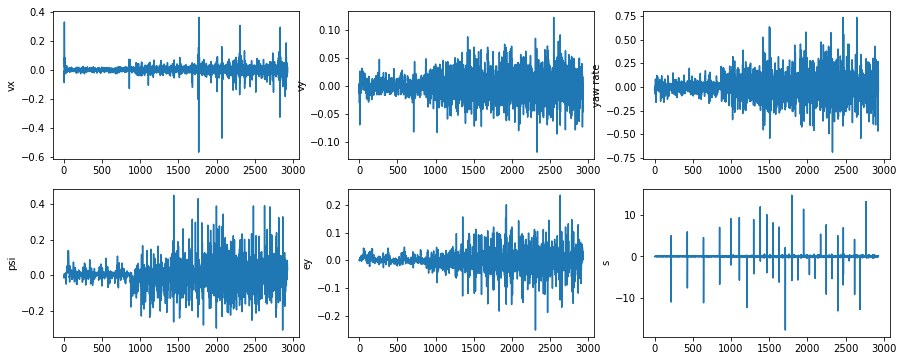

In [110]:

plt.figure(figsize=(15,6))
nstates = prediction_errors.shape[1]
state_names = ['vx', 'vy', 'yaw rate', 'psi', 'ey', 's']
for state in range(nstates):
    plt.subplot(nstates/3, 3, state+1)
    plt.plot(prediction_errors[:,state])
    #plt.scatter(range(len(cluster_labels)), prediction_errors[:,state], c=cluster_labels)
    plt.ylabel(state_names[state])
    

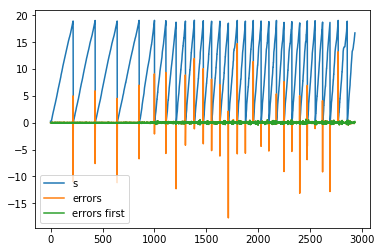

In [113]:
plt.figure(); 
plt.plot(z[:,5], label='s')
plt.plot(prediction_errors[:,5], label='errors')
plt.plot(prediction_errors_first[:,5], label='errors first')
plt.legend()

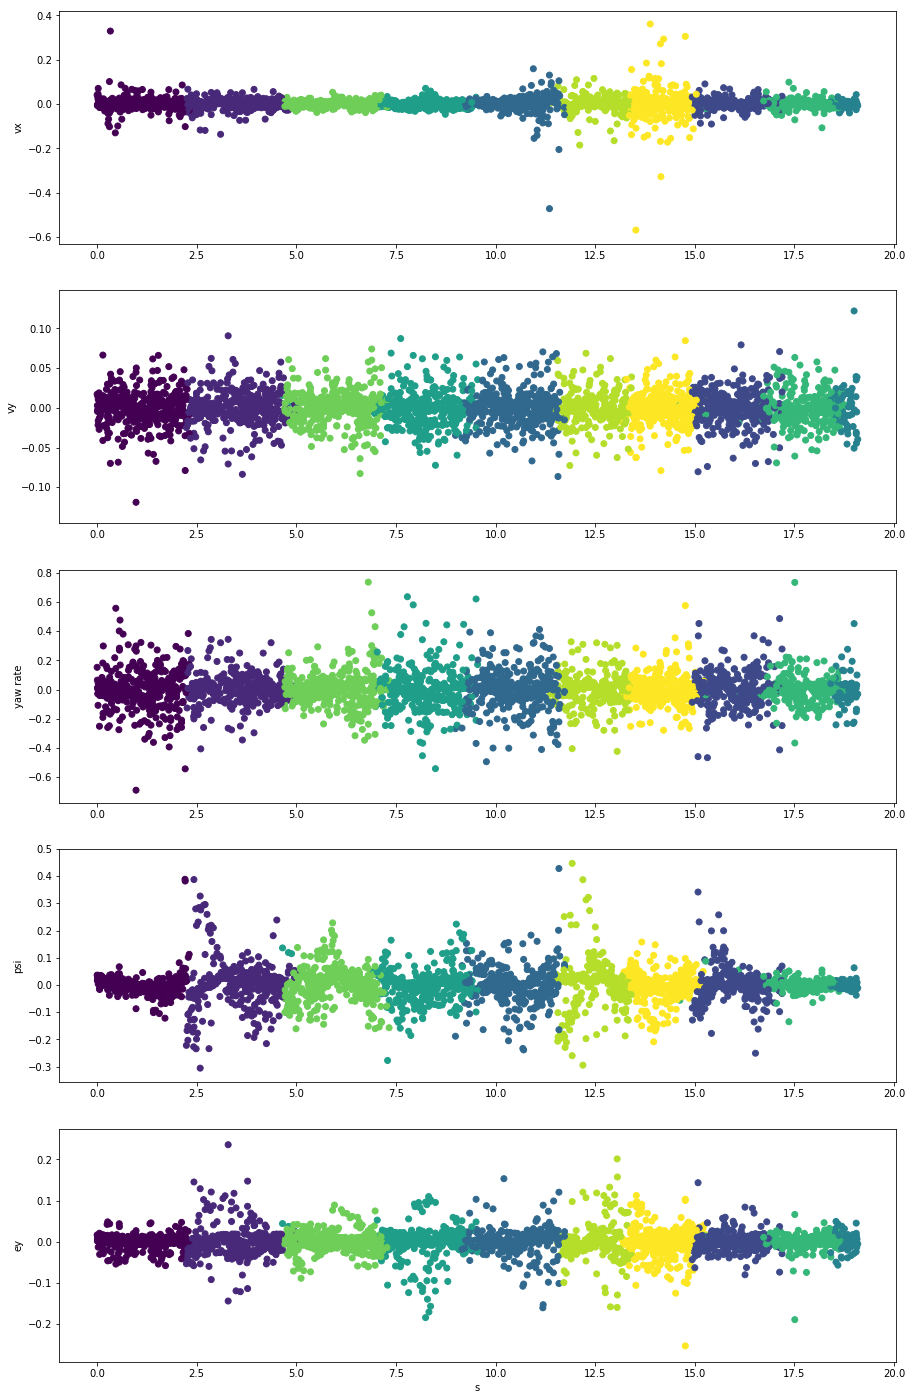

In [114]:
plt.figure(figsize=(15,30))
nstates = prediction_errors.shape[1]
state_names = ['vx', 'vy', 'yaw rate', 'psi', 'ey', 's']
for state in range(nstates-1):
    plt.subplot(nstates, 1, state+1)
    #plt.plot(z[:,5],prediction_errors[:,state])
    plt.scatter(z[:,5], prediction_errors[:,state], c=cluster_labels)
    plt.ylabel(state_names[state])
    if state == nstates-2:
        plt.xlabel('s')
        


In [33]:
len(cluster_labels)

2930

In [34]:
prediction_errors.shape

(2930, 6)